In [5]:
import os
import mne
import pandas as pd
import numpy as np
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

mne.set_log_level('WARNING')
print(f"PyTorch version: {torch.__version__}")
print(f"MNE version: {mne.__version__}")

PyTorch version: 2.9.1
MNE version: 1.11.0


<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-07 04:45:06 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: Surrogate>
>


/var/folders/_0/42rmq4zd6x79ldmdqt02pfcw0000gn/T/ipykernel_21205/973857018.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(eeg_file, preload=True)


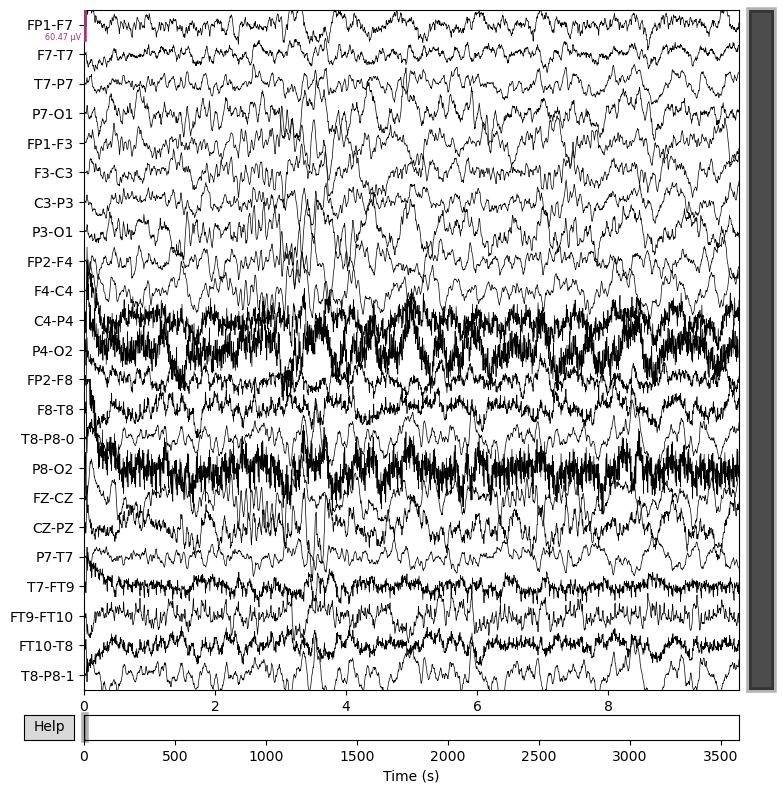

In [6]:
# Path to EEG data file (adjust to your path)
eeg_file = '/Users/rutvijsurti/Downloads/physionet.org/files/chbmit/1.0.0/chb01/chb01_18.edf'

# Read EEG data
raw = mne.io.read_raw_edf(eeg_file, preload=True)

# Print information
print(raw.info)

# Plot the raw EEG data
raw.plot(duration=10, n_channels=23, scalings='auto', title='Raw EEG Data')
plt.show()


In [7]:
# Define seizure time window
seizure_start = 2996
seizure_end = 3036

# Extract seizure data
seizure_data = raw.copy().crop(tmin=seizure_start, tmax=seizure_end)
seizure_label = 1

# Extract non-seizure data
no_seizure_1 = raw.copy().crop(tmin=0, tmax=seizure_start)
no_seizure_2 = raw.copy().crop(tmin=seizure_end, tmax=None)

# Concatenate non-seizure segments
no_seizure_data = mne.concatenate_raws([no_seizure_1, no_seizure_2])
no_seizure_label = 0

print(f"Seizure data duration: {seizure_data.times[-1]:.2f} seconds")
print(f"Non-seizure data duration: {no_seizure_data.times[-1]:.2f} seconds")


Seizure data duration: 40.00 seconds
Non-seizure data duration: 3560.00 seconds


In [8]:
def calculate_time_domain_features(data):
    """Compute time-domain features from EEG signal."""
    return {
        'mean': np.mean(data, axis=1),
        'std_dev': np.std(data, axis=1),
        'variance': np.var(data, axis=1),
        'skewness': skew(data, axis=1),
        'excess_kurtosis': kurtosis(data, axis=1)
    }

def calculate_frequency_domain_features(data, sampling_frequency):
    """Compute frequency-domain features (alpha power)."""
    psd_list = []
    for channel_data in data:
        freqs, psd = welch(channel_data, fs=sampling_frequency, 
                          nperseg=min(4*sampling_frequency, len(channel_data)))
        psd_list.append(psd)
    psd_array = np.array(psd_list)
    
    alpha_band = (8, 12)
    idx_alpha = np.logical_and(freqs >= alpha_band[0], freqs <= alpha_band[1])
    alpha_power = np.trapz(psd_array[:, idx_alpha], freqs[idx_alpha], axis=1)
    
    return {'alpha_power': alpha_power}

def calculate_features(raw_data):
    """Combine time and frequency domain features."""
    data = raw_data.get_data()
    sampling_frequency = raw_data.info['sfreq']
    
    time_features = calculate_time_domain_features(data)
    freq_features = calculate_frequency_domain_features(data, sampling_frequency)
    
    features = {**time_features, **freq_features}
    return pd.DataFrame(features)

print("Feature extraction functions defined successfully!")


Feature extraction functions defined successfully!


In [9]:
# Calculate features
seizure_features_df = calculate_features(seizure_data)
no_seizure_features_df = calculate_features(no_seizure_data)

# Add labels
seizure_features_df['label'] = 1
no_seizure_features_df['label'] = 0

# Combine features
combined_features_df = pd.concat([seizure_features_df, no_seizure_features_df], 
                                 ignore_index=True)

print(f"Combined features shape: {combined_features_df.shape}")
print(f"\nFeature columns: {combined_features_df.columns.tolist()}")
print(f"\nClass distribution:\n{combined_features_df['label'].value_counts()}")
combined_features_df.head()

/var/folders/_0/42rmq4zd6x79ldmdqt02pfcw0000gn/T/ipykernel_21205/2146309534.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  alpha_power = np.trapz(psd_array[:, idx_alpha], freqs[idx_alpha], axis=1)


Combined features shape: (46, 7)

Feature columns: ['mean', 'std_dev', 'variance', 'skewness', 'excess_kurtosis', 'alpha_power', 'label']

Class distribution:
label
1    23
0    23
Name: count, dtype: int64


,mean,std_dev,variance,skewness,excess_kurtosis,alpha_power,label
0,-2.981432e-07,0.000018,3.223423e-10,-0.125266,2.060319,5.616056e-12,1
1,4.343478e-07,0.000017,2.892854e-10,-0.584983,2.880881,6.990415e-12,1
2,4.506008e-07,0.000019,3.474288e-10,-0.204670,0.407743,9.703039e-12,1
3,2.962356e-07,0.000016,2.603682e-10,0.077368,0.419609,1.004319e-11,1
4,-8.006315e-08,0.000024,5.830923e-10,-0.077330,0.721352,9.904707e-12,1


In [10]:
# Separate features and labels
X = combined_features_df.drop('label', axis=1)
y = combined_features_df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 80/10/10 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (36, 6)
Validation set: (5, 6)
Test set: (5, 6)


In [11]:
device = torch.device('cpu')
print(f"Using device: {device}")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # (N, 1, 6)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)

X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Data prepared for PyTorch CNN")

Using device: cpu
Data prepared for PyTorch CNN


In [12]:
class EEG_CNN(nn.Module):
    def __init__(self):
        super(EEG_CNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.dropout2 = nn.Dropout(0.25)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        
        # Activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        
        # Fully connected
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

# Initialize model
model = EEG_CNN().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


EEG_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 20,769


In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training history storage
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Training setup complete!")

Training setup complete!


In [14]:
num_epochs = 50
best_val_acc = 0.0

print("=" * 70)
print("TRAINING CNN MODEL")
print("=" * 70)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_eeg_cnn_pytorch.pth')
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("=" * 70)
print(f"Training Complete! Best Validation Accuracy: {best_val_acc:.4f}")
print("=" * 70)

TRAINING CNN MODEL
Epoch 5/50
  Train Loss: 0.6348 | Train Acc: 0.8056
  Val Loss: 0.6735 | Val Acc: 0.6000
Epoch 10/50
  Train Loss: 0.5002 | Train Acc: 0.8889
  Val Loss: 0.6487 | Val Acc: 0.6000
Epoch 15/50
  Train Loss: 0.3140 | Train Acc: 0.9167
  Val Loss: 0.6475 | Val Acc: 0.6000
Epoch 20/50
  Train Loss: 0.2594 | Train Acc: 0.9444
  Val Loss: 0.6479 | Val Acc: 0.6000
Epoch 25/50
  Train Loss: 0.1446 | Train Acc: 0.9167
  Val Loss: 0.8425 | Val Acc: 0.6000
Epoch 30/50
  Train Loss: 0.1030 | Train Acc: 0.9167
  Val Loss: 0.8919 | Val Acc: 0.6000
Epoch 35/50
  Train Loss: 0.3446 | Train Acc: 0.9444
  Val Loss: 1.0055 | Val Acc: 0.6000
Epoch 40/50
  Train Loss: 0.1153 | Train Acc: 0.8889
  Val Loss: 1.1293 | Val Acc: 0.6000
Epoch 45/50
  Train Loss: 0.1305 | Train Acc: 0.9444
  Val Loss: 1.0160 | Val Acc: 0.6000
Epoch 50/50
  Train Loss: 0.0971 | Train Acc: 0.9444
  Val Loss: 0.6977 | Val Acc: 0.6000
Training Complete! Best Validation Accuracy: 0.8000


In [15]:
model.load_state_dict(torch.load('best_eeg_cnn_pytorch.pth'))
model.eval()

y_val_pred_list = []
y_val_proba_list = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        
        y_val_pred_list.extend(predicted.cpu().numpy())
        y_val_proba_list.extend(outputs.cpu().numpy())

y_val_pred = np.array(y_val_pred_list).flatten()
y_val_proba = np.array(y_val_proba_list).flatten()
y_val_true = y_val.values

# Calculate metrics
val_acc = accuracy_score(y_val_true, y_val_pred)
val_prec = precision_score(y_val_true, y_val_pred)
val_rec = recall_score(y_val_true, y_val_pred)
val_f1 = f1_score(y_val_true, y_val_pred)

print("=" * 70)
print("VALIDATION SET PERFORMANCE")
print("=" * 70)
print(f"Accuracy:  {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1-Score:  {val_f1:.4f}")
print("=" * 70)

VALIDATION SET PERFORMANCE
Accuracy:  0.8000
Precision: 1.0000
Recall:    0.6667
F1-Score:  0.8000


In [16]:
y_test_pred_list = []
y_test_proba_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        
        y_test_pred_list.extend(predicted.cpu().numpy())
        y_test_proba_list.extend(outputs.cpu().numpy())

y_test_pred = np.array(y_test_pred_list).flatten()
y_test_proba = np.array(y_test_proba_list).flatten()
y_test_true = y_test.values

# Calculate metrics
test_acc = accuracy_score(y_test_true, y_test_pred)
test_prec = precision_score(y_test_true, y_test_pred)
test_rec = recall_score(y_test_true, y_test_pred)
test_f1 = f1_score(y_test_true, y_test_pred)

print("=" * 70)
print("TEST SET PERFORMANCE")
print("=" * 70)
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall:    {test_rec:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")
print("=" * 70)

TEST SET PERFORMANCE
Test Accuracy:  0.8000
Test Precision: 1.0000
Test Recall:    0.5000
Test F1-Score:  0.6667


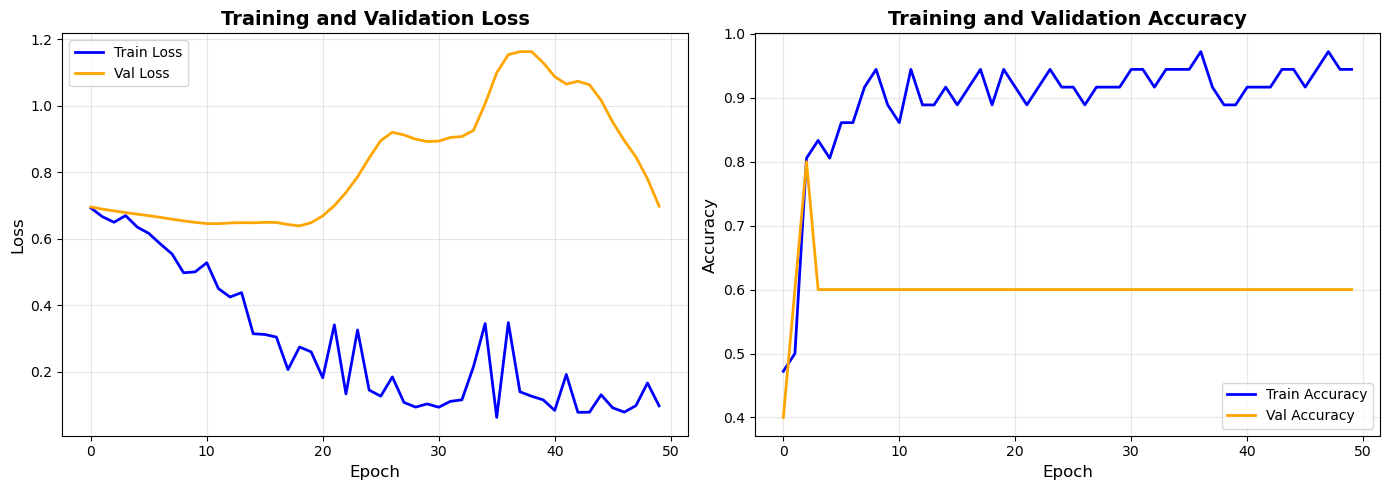

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, color='orange')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2, color='blue')
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

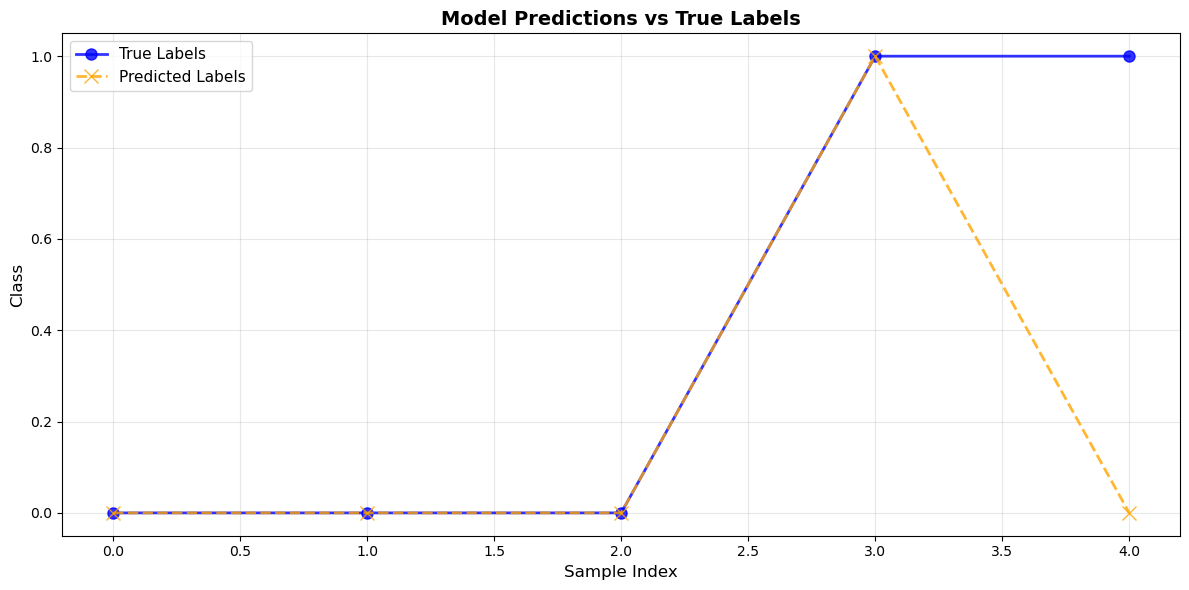

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_true, 'o-', label='True Labels', alpha=0.8, 
         markersize=8, linewidth=2, color='blue')
plt.plot(y_test_pred, 'x--', label='Predicted Labels', alpha=0.8, 
         markersize=10, linewidth=2, color='orange')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.title('Model Predictions vs True Labels', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

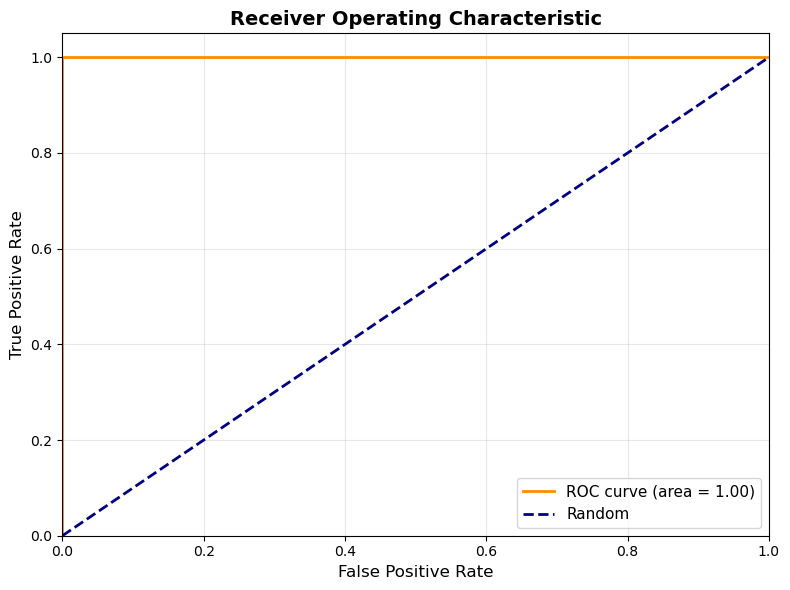

In [19]:
fpr, tpr, thresholds = roc_curve(y_test_true, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

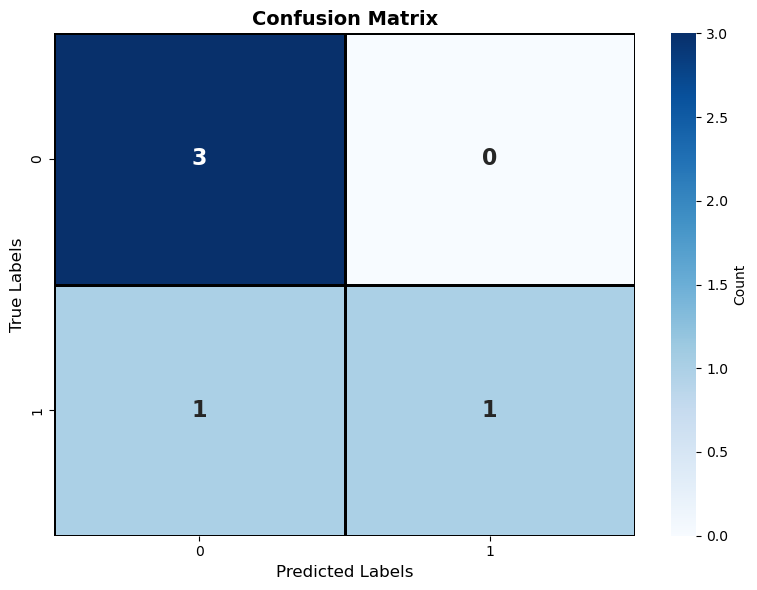

In [20]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black',
            annot_kws={'size': 16, 'weight': 'bold'})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
